Candidate: Kumutha S.Ramachanidran
#
Date: 11/01/2023
#
Assessment: 3
#
1. Link to the dataset:
https://data.mendeley.com/datasets/5y9wdsg2zt/2
2. Carry out the whole machine learning workflow for this project (Problem
Formulation →Data Preparation→Model Development→Model
Deployment)
3. For criteria, try to achieve training and validation accuracy of more than 90%
4. Make sure your model is not overfitting.
5. You may apply transfer learning.
6. When uploading to GitHub, make sure your whole project is presentable:
a. Make sure you have a complete README file.
b. You do not need to upload the data onto GitHub, just mention the data
source in your README.
c. Make sure you write your code following the good practices such as
following variable naming conventions and writing concise comments
to improve the readability of your code.
7. For model deployment, try to use the model to make some predictions with
your test data.

In [1]:
#importing important libraries and modules
import os
import glob
import pickle 
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,optimizers,losses,metrics,callbacks,applications

In [2]:
#to name the folder path and to return positive and negative folder in one path
main_path = r"C:\Users\User\Desktop\Assessment\Assessment_3\datasets/" 
concat_data_path = list(glob.glob(main_path+'**/*jpg')) #to return all files under the main_path_folder
negative_label_path = main_path + 'Negative/*.jpg'
positive_label_path = main_path + 'Positive/*.jpg'

In [3]:
#To concatenate both images (positive and negative) into a dataset
#list down all images in list
all_labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],concat_data_path)) #size 40000
dataset_path = pd.Series(concat_data_path, name='dataset_path').astype(str)
all_labels = pd.Series(all_labels, name='Label')
df_image = pd.concat([dataset_path,all_labels], axis=1) 
df_image =df_image.sample(frac=1).reset_index(drop=True) #to reset index in default value


In [4]:
#data inspection 
df_image.head()

dataset_path     Label
0  C:\Users\User\Desktop\Assessment\Assessment_3\...  Negative
1  C:\Users\User\Desktop\Assessment\Assessment_3\...  Positive
2  C:\Users\User\Desktop\Assessment\Assessment_3\...  Negative
3  C:\Users\User\Desktop\Assessment\Assessment_3\...  Positive
4  C:\Users\User\Desktop\Assessment\Assessment_3\...  Positive

In [5]:
#to transform dataframe into string
data = df_image.to_string() 


In [6]:
#to create train and test path from the dataset data
train_path = os.path.join(data,main_path)
test_path = os.path.join(data,main_path)

In [7]:
#assigned the batch size and image size 
BATCH_SIZE = 32
IMG_SIZE = (160,160)
train_dataset = keras.utils.image_dataset_from_directory(train_path,batch_size=BATCH_SIZE,image_size=IMG_SIZE,shuffle=True)

test_dataset = keras.utils.image_dataset_from_directory(test_path,batch_size=BATCH_SIZE,image_size=IMG_SIZE,shuffle=True)

class_names = train_dataset.class_names

Found 40000 files belonging to 2 classes.
Found 40000 files belonging to 2 classes.


In [8]:
#convert batchdataset into prefetchdataset

AUTOTUNE = tf.data.AUTOTUNE 
train_df = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_df = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
#CREATE A SMALL PIPELINE 
#create a small pipeline for data augmentation 
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))

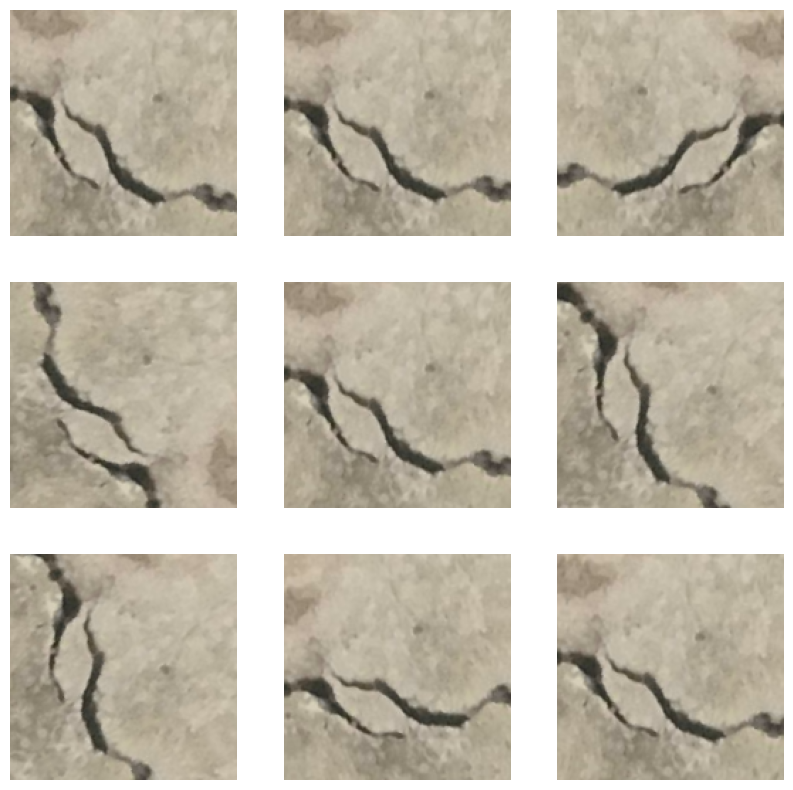

In [10]:
#APPLY THE DATA AUGMENTATION TO TEST IT OUT

for image,labels in train_df.take(1):
    first_image = image[0]
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,axis=0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis('off')

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 80, 80, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 80, 80, 16)  64          ['Conv[0][0]']    

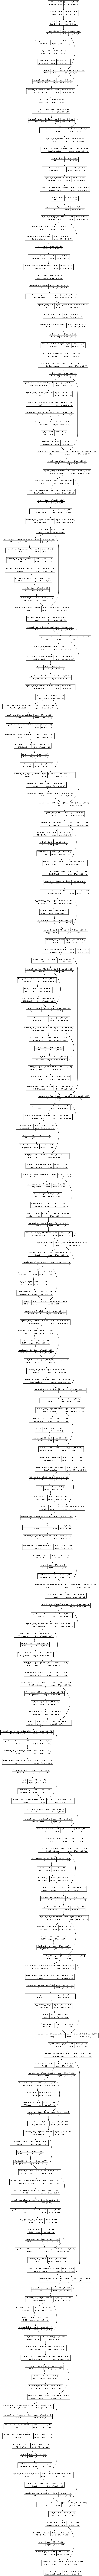

In [11]:

#apply transfer learning
#import mobilenetv3 large
IMG_SHAPE = IMG_SIZE + (3,)
feature_extractor = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,include_top=False,weights='imagenet',pooling='avg')

feature_extractor.summary()
#can plot if needed the model
keras.utils.plot_model(feature_extractor,show_shapes=True)

In [12]:
#define the classification layer
l2 = keras.regularizers.L2()
output_layer = layers.Dense(len(class_names),activation='softmax',kernel_regularizer=l2)

In [13]:
#feature_extractor.trainable = False
inputs = keras.Input(shape=IMG_SHAPE)

In [14]:
x = data_augmentation(inputs)
x = feature_extractor(x)
x = layers.Dropout(0.3)(x) #optional if not overfitting 
outputs = output_layer(x)

In [15]:
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()  
#model have been created

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 2)                 1922      
                                                                 
Total params: 2,998,274
Trainable params: 2,973,874
Non-trainable params: 24,400
______________________________________________

In [16]:
#now need to compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [17]:
#evaluate before model training 
loss0, acc0 = model.evaluate(test_df)
print("Loss = ", loss0)
print("Accuracy =",acc0)

1250/1250 [==============================] - 371s 295ms/step - loss: 0.8461 - accuracy: 0.4588
Loss =  0.8460921049118042
Accuracy = 0.45877501368522644


In [18]:
#create the tensorboard callback
import datetime
log_path = os.path.join('log_dir', 'tl_demo', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(log_dir=log_path)

In [20]:
#now model training
EPOCHS = 1
history = model.fit(train_df,validation_data=test_df,epochs=EPOCHS,callbacks=[tb])

1250/1250 [==============================] - 1930s 2s/step - loss: 0.0501 - accuracy: 0.9958 - val_loss: 0.0366 - val_accuracy: 0.9983


In [21]:
#apply model fine tune
feature_extractor.trainable = True 

for layer in feature_extractor.layers[:132]:
    layer.trainable = False 

model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x0000021DB9DBF250>>

In [22]:
#model compile
optimizer = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [23]:
#continue the model training
fine_tune_epoch = 1
total_epoch = EPOCHS + fine_tune_epoch
history_fine = model.fit(train_df,validation_data=test_df,epochs=total_epoch,initial_epoch=history.epoch[-1],callbacks=[tb])

Epoch 1/2
1250/1250 [==============================] - 1089s 866ms/step - loss: 0.0321 - accuracy: 0.9984 - val_loss: 0.0261 - val_accuracy: 0.9993
Epoch 2/2
1250/1250 [==============================] - 1197s 958ms/step - loss: 0.0248 - accuracy: 0.9986 - val_loss: 0.0195 - val_accuracy: 0.9994


In [24]:
#evaluate model
test_loss, test_acc = model.evaluate(test_df)
print("Loss = ", test_loss)
print("Accuracy = ",test_acc)

1250/1250 [==============================] - 354s 283ms/step - loss: 0.0195 - accuracy: 0.9994
Loss =  0.01950893923640251
Accuracy =  0.9994249939918518


In [25]:
#model deployment 
image_batch,label_batch = test_df.as_numpy_iterator().next()
y_pred = np.argmax(model.predict(image_batch), axis=1)

1/1 [==============================] - 1s 1s/step


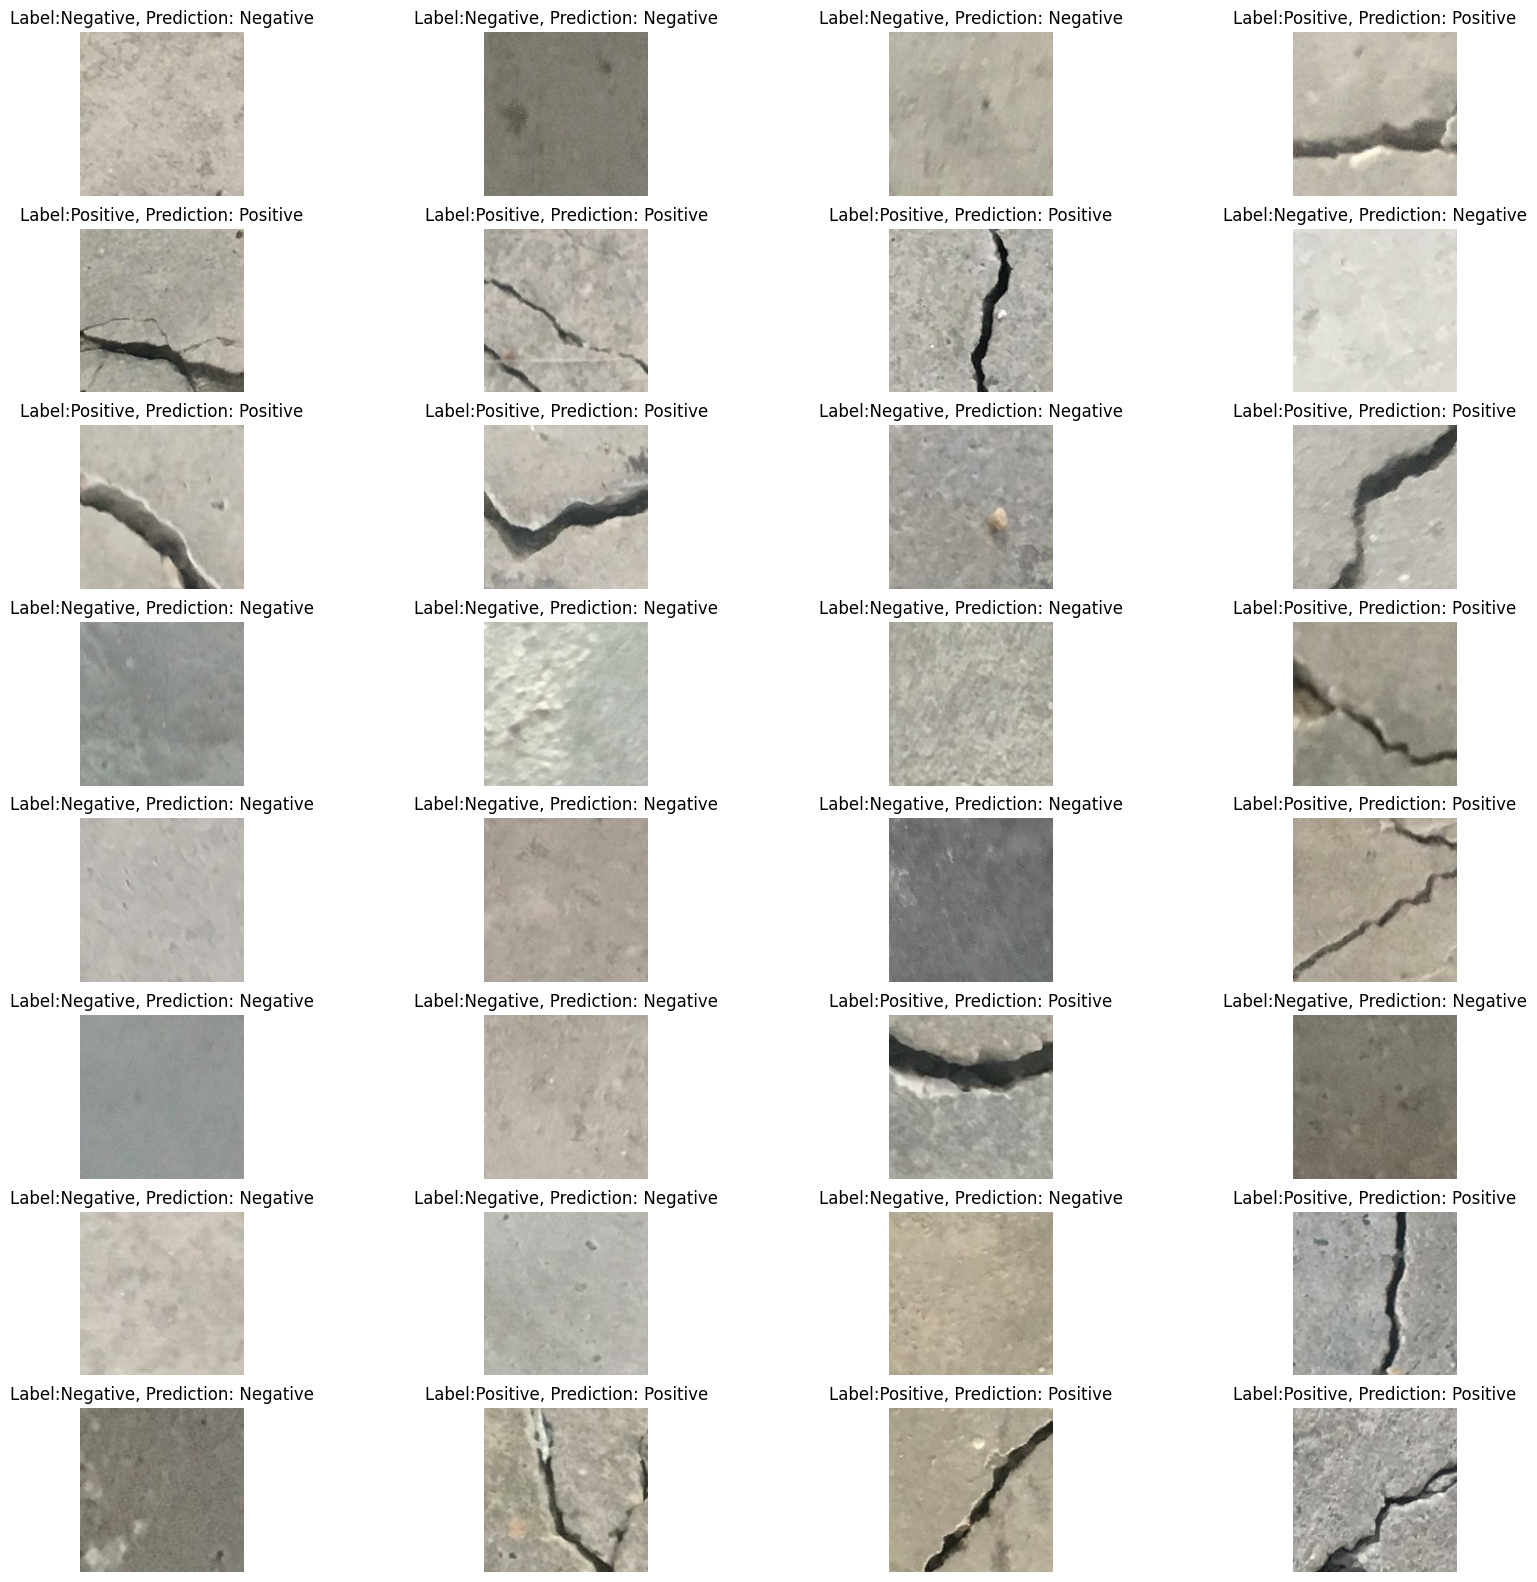

In [26]:
plt.figure(figsize=(20,20))

for i in range(len(image_batch)):
    plt.subplot(8,4,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"Label:{class_names[label_batch[i]]}, Prediction: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.show()


In [27]:
#to save trained model 
model.save('image_classification.h5')